In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

!pip install fairlearn
from fairlearn.reductions import GridSearch, DemographicParity, EqualizedOdds, ExponentiatedGradient
from fairlearn.metrics import MetricFrame, false_positive_rate, false_negative_rate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Define a function to measure ethnic bias (FPR/FNR difference across races)
def measure_bias(X_eval, y_eval, y_pred_eval, race_column_encoded):
    df_eval = X_eval.copy()
    df_eval['race'] = df.loc[X_eval.index, race_column_encoded].map(race_mapping)
    df_eval['y_true'] = y_eval
    df_eval['y_pred'] = y_pred_eval

    results = []
    for race_name in df_eval['race'].unique():
        group = df_eval[df_eval['race'] == race_name]
        cm = confusion_matrix(group['y_true'], group['y_pred'], labels=[0,1])
        if cm.shape == (2,2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0
        total = len(group)
        fpr = fp / (fp + tn) if (fp + tn) else 0
        fnr = fn / (fn + tp) if (fn + tp) else 0
        results.append({'race': race_name, 'FPR': fpr, 'FNR': fnr, 'total': total})
    return pd.DataFrame(results)

In [ ]:
# Load the data
df = pd.read_csv('compas-scores-two-years.csv')


In [ ]:
# Basic info about columns
print("\n Basic dataset info:")
print(df.info())

print("\n Number of missing values:")
print(df.isnull().sum())

print("\n Descriptive statistics:")
print(df.describe(include='all'))


 Basic dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  pr

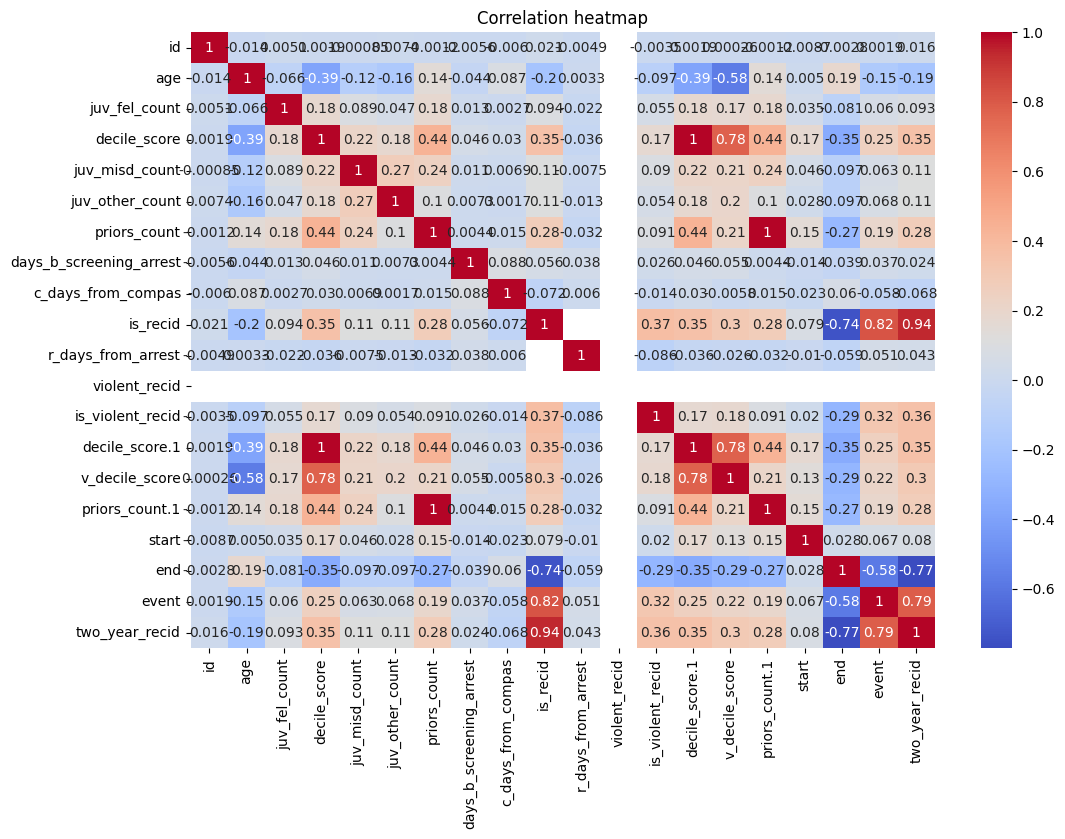

In [ ]:
# Correlation heatmap for numeric variables
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

In [ ]:
# Drop columns that are identifiers, dates, text descriptions or clearly not useful for prediction
drop_cols = [
    'id', 'name', 'first', 'last', 'dob', 'compas_screening_date',
    'dob', 'age_cat', 'decile_score', 'days_b_screening_arrest',
    'c_case_number', 'c_days_from_compas', 'c_jail_in', 'c_jail_out',
    'r_case_number', 'r_offense_date', 'r_charge_degree', 'r_days_from_arrest',
    'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
    'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
    'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
    'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date',
    'priors_count.1', 'start', 'end', 'event'
]
df = df.drop(columns=drop_cols, errors='ignore')

# Convert the date columns to datetime if they aren’t already
df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'], errors='coerce')
df['c_offense_date'] = pd.to_datetime(df['c_offense_date'], errors='coerce')
df['in_custody'] = pd.to_datetime(df['in_custody'], errors='coerce')
df['out_custody'] = pd.to_datetime(df['out_custody'], errors='coerce')

# Merge: take c_arrest_date if available, else c_offense_date
df['c_event_date'] = df['c_arrest_date'].combine_first(df['c_offense_date'])

# New feature: days between in_custody and c_event_date
df['days_before_custody'] = (df['in_custody'] - df['c_event_date']).dt.days

# New feature: days in custody
df['days_in_custody'] = (df['out_custody'] - df['in_custody']).dt.days


# Delete dates
drop_dates = [
    'c_arrest_date', 'c_offense_date', 'in_custody', 'out_custody', 'c_event_date'
]
df = df.drop(columns=drop_dates, errors='ignore')


In [ ]:
# Remove duplicate columns (priors_count and decile_score appear twice in your list)
df = df.loc[:,~df.columns.duplicated()]


In [ ]:
# Encode categorical variables
categorical_cols = df.select_dtypes(include='object').columns
print(f"\n Categorical columns: {categorical_cols}")

encoders = {}
le = LabelEncoder()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str).fillna('missing')
    df[col] = le.fit_transform(df[col])
    encoders[col] = le


 Categorical columns: Index(['sex', 'race', 'c_charge_degree', 'c_charge_desc'], dtype='object')


In [ ]:
# Fill numeric missing values with median
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
# Define target and features
target_1 = 'two_year_recid'
target_2 = 'is_recid'
target_3 = 'is_violent_recid'
target_4 = 'violent_recid'
X = df.drop(columns=[target_1, target_2, target_3, target_4], errors='ignore')
y = df[target_1]

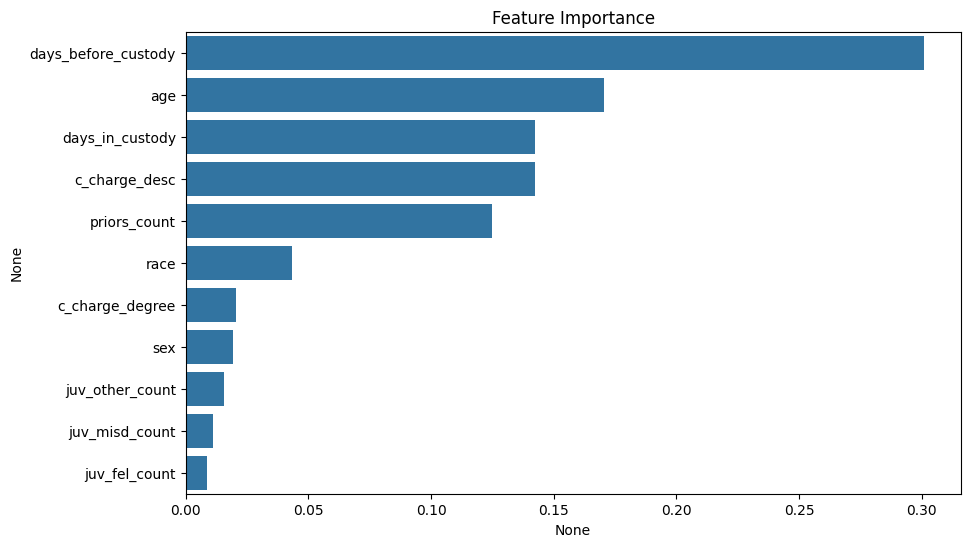


 Most important features:
days_before_custody    0.300827
age                    0.170534
days_in_custody        0.142314
c_charge_desc          0.142290
priors_count           0.125049
race                   0.043241
c_charge_degree        0.020683
sex                    0.019394
juv_other_count        0.015565
juv_misd_count         0.011333
juv_fel_count          0.008770
dtype: float64


In [ ]:
# Feature importance: first we train a quick RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Plot feature importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title('Feature Importance')
plt.show()

print("\n Most important features:")
print(feat_importances)

# Naive model


 Classification report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1023
           1       0.72      0.77      0.74       781

    accuracy                           0.77      1804
   macro avg       0.77      0.77      0.77      1804
weighted avg       0.77      0.77      0.77      1804


 ROC AUC Score: 0.8391


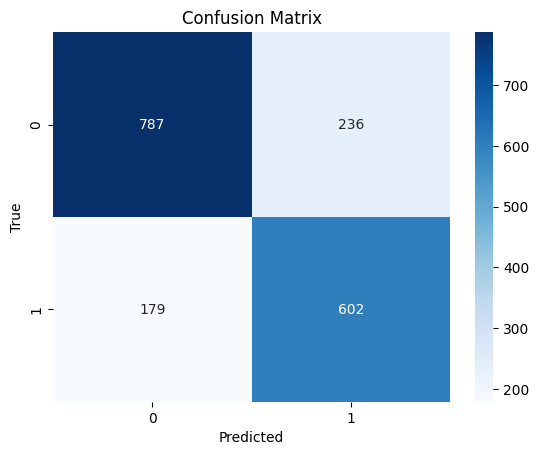

In [ ]:
# Build train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

naive_model = RandomForestClassifier(n_estimators=500, random_state=42)
naive_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = naive_model.predict(X_test)
y_proba = naive_model.predict_proba(X_test)[:, 1]

print("\n Classification report:")
print(classification_report(y_test, y_pred))

print(f"\n ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
race_mapping = dict(enumerate(encoders['race'].classes_))

initial_bias_df = measure_bias(X_test, y_test, y_pred, 'race')
print("\n Initial bias:")
print(initial_bias_df)

# Extract FPR and FNR for the two groups
fpr_afam = initial_bias_df.loc[initial_bias_df['race'] == 'African-American', 'FPR'].values
fpr_cauc = initial_bias_df.loc[initial_bias_df['race'] == 'Caucasian', 'FPR'].values
fnr_afam = initial_bias_df.loc[initial_bias_df['race'] == 'African-American', 'FNR'].values
fnr_cauc = initial_bias_df.loc[initial_bias_df['race'] == 'Caucasian', 'FNR'].values

# Compute differences safely
fpr_diff = fpr_afam[0] - fpr_cauc[0] if len(fpr_afam) and len(fpr_cauc) else None
fnr_diff = fnr_afam[0] - fnr_cauc[0] if len(fnr_afam) and len(fnr_cauc) else None

print("\nDifference in FPR/FNR:")
print(f"FPR_diff: {fpr_diff}")
print(f"FNR_diff: {fnr_diff}")


 Initial bias:
               race       FPR       FNR  total
0         Caucasian  0.173913  0.262931    623
1  African-American  0.292411  0.189765    917
2             Other  0.200000  0.294118    104
3          Hispanic  0.186916  0.409091    151
4   Native American  1.000000  1.000000      3
5             Asian  0.200000  0.000000      6

Difference in FPR/FNR:
FPR_diff: 0.11849767080745344
FNR_diff: -0.07316557606058377


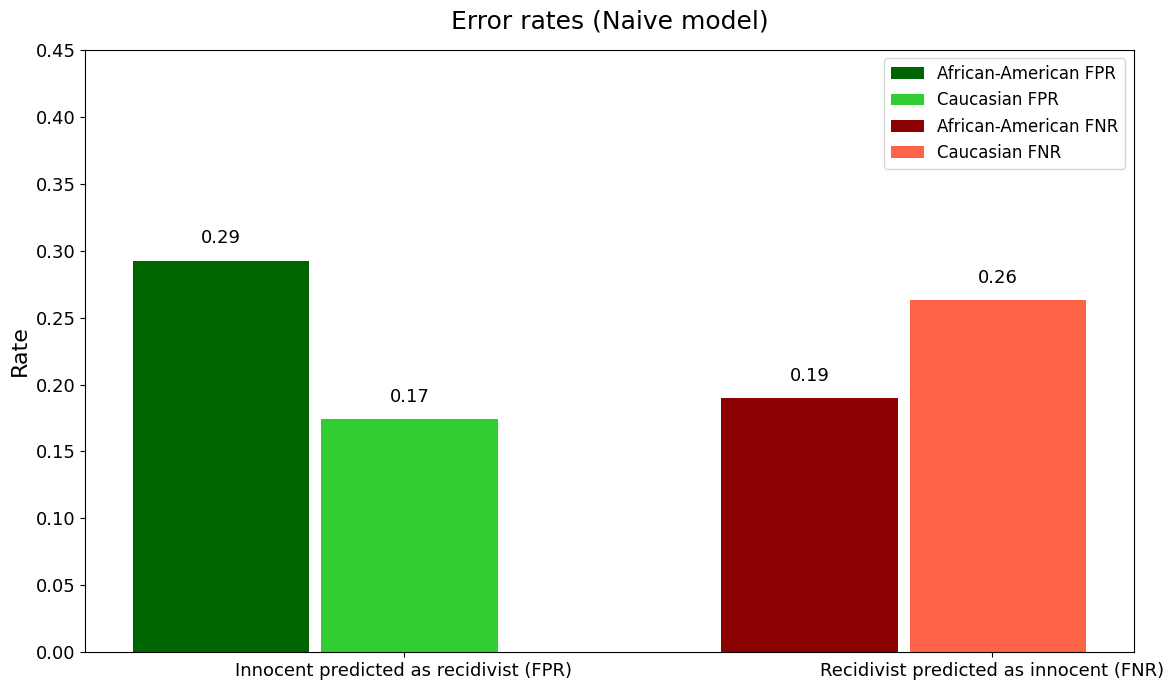

In [ ]:
# --------------------------
# 📊 Diagrama de barras verticales con etiquetas claras
# --------------------------
labels = [
    'Innocent predicted as recidivist (FPR)',
    'Recidivist predicted as innocent (FNR)'
]

# Valores
aa_values = [fpr_afam[0], fnr_afam[0]]
cauc_values = [fpr_cauc[0], fnr_cauc[0]]

x = range(len(labels))
bar_width = 0.3
separation = 0.02

fig, ax = plt.subplots(figsize=(12,7))

# Colores
color_aa_fpr = '#006400'   # verde oscuro
color_aa_fnr = '#8B0000'   # verde claro
color_cauc_fpr = '#32CD32' # rojo oscuro
color_cauc_fnr = '#FF6347' # rojo claro

# Barras FPR
ax.bar(
    0 - bar_width - separation/2,
    aa_values[0],
    width=bar_width,
    label='African-American FPR',
    color=color_aa_fpr
)
ax.bar(
    0 + separation/2,
    cauc_values[0],
    width=bar_width,
    label='Caucasian FPR',
    color=color_cauc_fpr
)

# Barras FNR
ax.bar(
    1 - bar_width - separation/2,
    aa_values[1],
    width=bar_width,
    label='African-American FNR',
    color=color_aa_fnr
)
ax.bar(
    1 + separation/2,
    cauc_values[1],
    width=bar_width,
    label='Caucasian FNR',
    color=color_cauc_fnr
)

# Etiquetas y detalles
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14, wrap=True)  # wrap para texto largo
ax.set_ylabel('Rate', fontsize=16)
ax.set_ylim([0,0.45])
ax.set_title('Error rates (Naive model)', fontsize=18, pad=15)
ax.legend(fontsize=12)

# Mostrar valores encima de las barras
for xpos, value in zip([0 - bar_width - separation/2, 1 - bar_width - separation/2], aa_values):
    ax.text(xpos, value + 0.01, f"{value:.2f}", ha='center', va='bottom', fontsize=13)
for xpos, value in zip([0 + separation/2, 1 + separation/2], cauc_values):
    ax.text(xpos, value + 0.01, f"{value:.2f}", ha='center', va='bottom', fontsize=13)

# Ejes más grandes
ax.tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
plt.show()

# Removing ethnic bias

In [ ]:
for feature in X.columns:
    corr = np.corrcoef(X[feature], (df['race'] == encoders['race'].transform(['African-American'])[0]).astype(int))[0,1]
    print(f"{feature}: corr with African-American: {corr:.3f}")

sex: corr with African-American: 0.044
age: corr with African-American: -0.179
race: corr with African-American: -0.882
juv_fel_count: corr with African-American: 0.071
juv_misd_count: corr with African-American: 0.096
juv_other_count: corr with African-American: 0.052
priors_count: corr with African-American: 0.203
c_charge_degree: corr with African-American: -0.091
c_charge_desc: corr with African-American: 0.055
days_before_custody: corr with African-American: 0.043
days_in_custody: corr with African-American: 0.068



 Classification report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.78      1023
           1       0.71      0.76      0.73       781

    accuracy                           0.76      1804
   macro avg       0.76      0.76      0.76      1804
weighted avg       0.76      0.76      0.76      1804


 ROC AUC Score: 0.8297


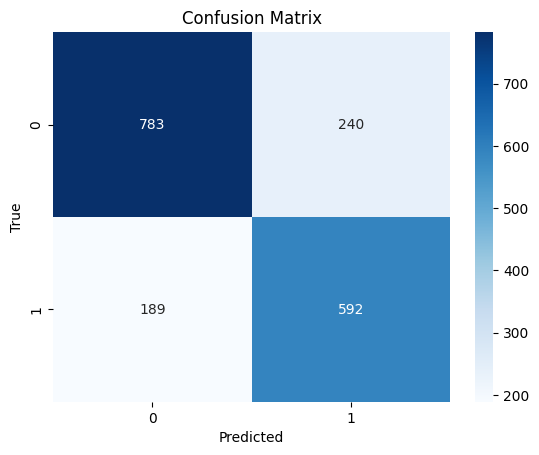

In [ ]:
X_no_race = X.drop(columns=['race'], errors='ignore')

# Build train/test split
X_train, X_test, y_train, y_test = train_test_split(X_no_race, y, test_size=0.25, random_state=42)

naive_model = RandomForestClassifier(n_estimators=500, random_state=42)
naive_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = naive_model.predict(X_test)
y_proba = naive_model.predict_proba(X_test)[:, 1]

print("\n Classification report:")
print(classification_report(y_test, y_pred))

print(f"\n ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
modified_bias_df = measure_bias(X_test, y_test, y_pred, 'race')
print("\n Modified bias:")
print(modified_bias_df)

# Extract FPR and FNR for the two groups
fpr_afam = modified_bias_df.loc[modified_bias_df['race'] == 'African-American', 'FPR'].values
fpr_cauc = modified_bias_df.loc[modified_bias_df['race'] == 'Caucasian', 'FPR'].values
fnr_afam = modified_bias_df.loc[modified_bias_df['race'] == 'African-American', 'FNR'].values
fnr_cauc = modified_bias_df.loc[modified_bias_df['race'] == 'Caucasian', 'FNR'].values

# Compute differences safely
fpr_diff = fpr_afam[0] - fpr_cauc[0] if len(fpr_afam) and len(fpr_cauc) else None
fnr_diff = fnr_afam[0] - fnr_cauc[0] if len(fnr_afam) and len(fnr_cauc) else None

print("\nDifference in FPR/FNR:")
print(f"FPR_diff: {fpr_diff}")
print(f"FNR_diff: {fnr_diff}")


 Modified bias:
               race       FPR       FNR  total
0         Caucasian  0.194373  0.271552    623
1  African-American  0.272321  0.204691    917
2             Other  0.228571  0.294118    104
3          Hispanic  0.214953  0.454545    151
4   Native American  1.000000  0.000000      3
5             Asian  0.200000  0.000000      6

Difference in FPR/FNR:
FPR_diff: 0.07794802703690171
FNR_diff: -0.06686089258142786


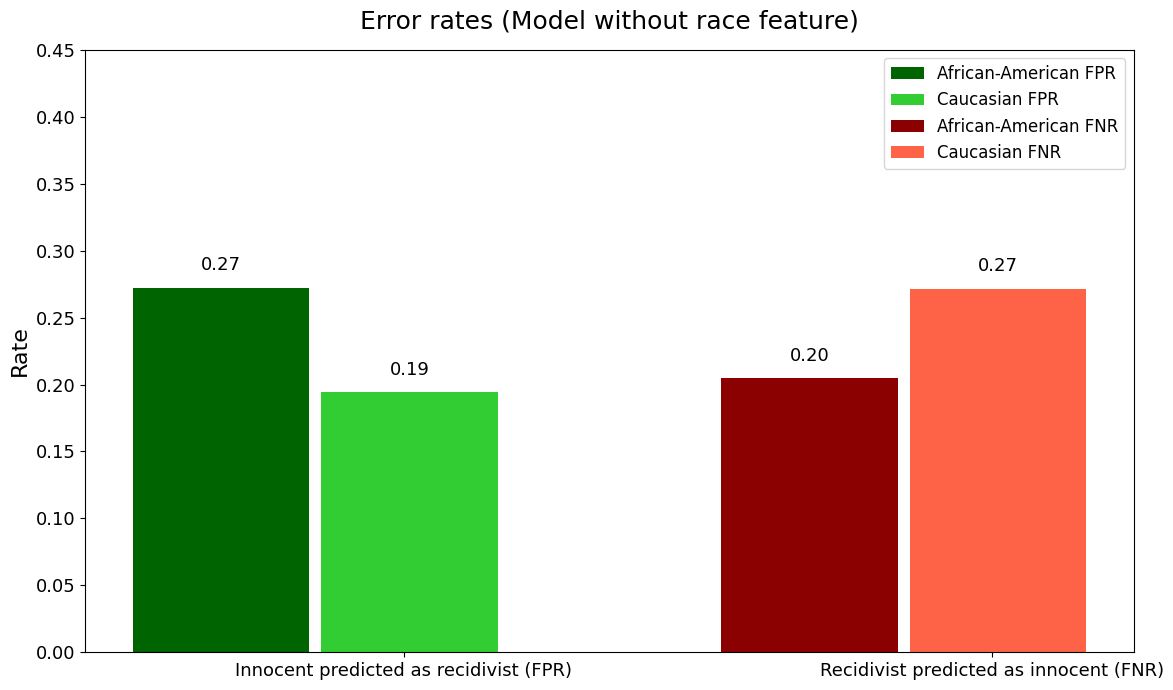

In [ ]:
# --------------------------
# 📊 Diagrama de barras verticales con etiquetas claras
# --------------------------
labels = [
    'Innocent predicted as recidivist (FPR)',
    'Recidivist predicted as innocent (FNR)'
]

# Valores
aa_values = [fpr_afam[0], fnr_afam[0]]
cauc_values = [fpr_cauc[0], fnr_cauc[0]]

x = range(len(labels))
bar_width = 0.3
separation = 0.02

fig, ax = plt.subplots(figsize=(12,7))

# Colores
color_aa_fpr = '#006400'   # verde oscuro
color_aa_fnr = '#8B0000'   # verde claro
color_cauc_fpr = '#32CD32' # rojo oscuro
color_cauc_fnr = '#FF6347' # rojo claro

# Barras FPR
ax.bar(
    0 - bar_width - separation/2,
    aa_values[0],
    width=bar_width,
    label='African-American FPR',
    color=color_aa_fpr
)
ax.bar(
    0 + separation/2,
    cauc_values[0],
    width=bar_width,
    label='Caucasian FPR',
    color=color_cauc_fpr
)

# Barras FNR
ax.bar(
    1 - bar_width - separation/2,
    aa_values[1],
    width=bar_width,
    label='African-American FNR',
    color=color_aa_fnr
)
ax.bar(
    1 + separation/2,
    cauc_values[1],
    width=bar_width,
    label='Caucasian FNR',
    color=color_cauc_fnr
)

# Etiquetas y detalles
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14, wrap=True)  # wrap para texto largo
ax.set_ylabel('Rate', fontsize=16)
ax.set_ylim([0,0.45])
ax.set_title('Error rates (Model without race feature)', fontsize=18, pad=15)
ax.legend(fontsize=12)

# Mostrar valores encima de las barras
for xpos, value in zip([0 - bar_width - separation/2, 1 - bar_width - separation/2], aa_values):
    ax.text(xpos, value + 0.01, f"{value:.2f}", ha='center', va='bottom', fontsize=13)
for xpos, value in zip([0 + separation/2, 1 + separation/2], cauc_values):
    ax.text(xpos, value + 0.01, f"{value:.2f}", ha='center', va='bottom', fontsize=13)

# Ejes más grandes
ax.tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
plt.show()


 Classification report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1023
           1       0.67      0.70      0.68       781

    accuracy                           0.72      1804
   macro avg       0.72      0.72      0.72      1804
weighted avg       0.72      0.72      0.72      1804


 ROC AUC Score: 0.7719


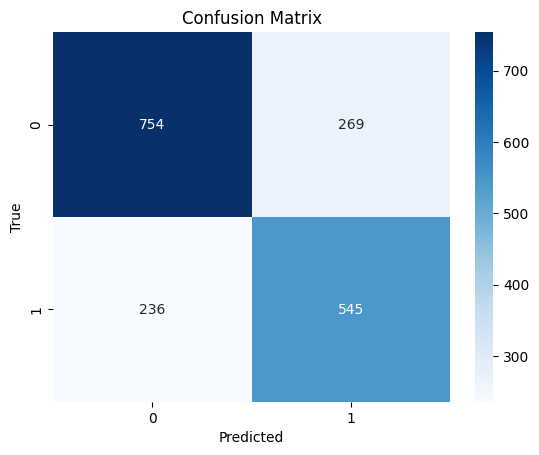

In [ ]:
X_less_proxy = X.drop(columns=['race', 'priors_count', 'age'], errors='ignore')

# Build train/test split
X_train, X_test, y_train, y_test = train_test_split(X_less_proxy, y, test_size=0.25, random_state=42)

naive_model = RandomForestClassifier(n_estimators=500, random_state=42)
naive_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = naive_model.predict(X_test)
y_proba = naive_model.predict_proba(X_test)[:, 1]

print("\n Classification report:")
print(classification_report(y_test, y_pred))

print(f"\n ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
modified_bias_df = measure_bias(X_test, y_test, y_pred, 'race')
print("\n Modified bias:")
print(modified_bias_df)

# Extract FPR and FNR for the two groups
fpr_afam = modified_bias_df.loc[modified_bias_df['race'] == 'African-American', 'FPR'].values
fpr_cauc = modified_bias_df.loc[modified_bias_df['race'] == 'Caucasian', 'FPR'].values
fnr_afam = modified_bias_df.loc[modified_bias_df['race'] == 'African-American', 'FNR'].values
fnr_cauc = modified_bias_df.loc[modified_bias_df['race'] == 'Caucasian', 'FNR'].values

# Compute differences safely
fpr_diff = fpr_afam[0] - fpr_cauc[0] if len(fpr_afam) and len(fpr_cauc) else None
fnr_diff = fnr_afam[0] - fnr_cauc[0] if len(fnr_afam) and len(fnr_cauc) else None

print("\nDifference in FPR/FNR:")
print(f"FPR_diff: {fpr_diff}")
print(f"FNR_diff: {fnr_diff}")


 Modified bias:
               race       FPR       FNR  total
0         Caucasian  0.214834  0.258621    623
1  African-American  0.303571  0.302772    917
2             Other  0.271429  0.382353    104
3          Hispanic  0.271028  0.477273    151
4   Native American  0.500000  0.000000      3
5             Asian  0.000000  0.000000      6

Difference in FPR/FNR:
FPR_diff: 0.0887376689806357
FNR_diff: 0.044151165355488575


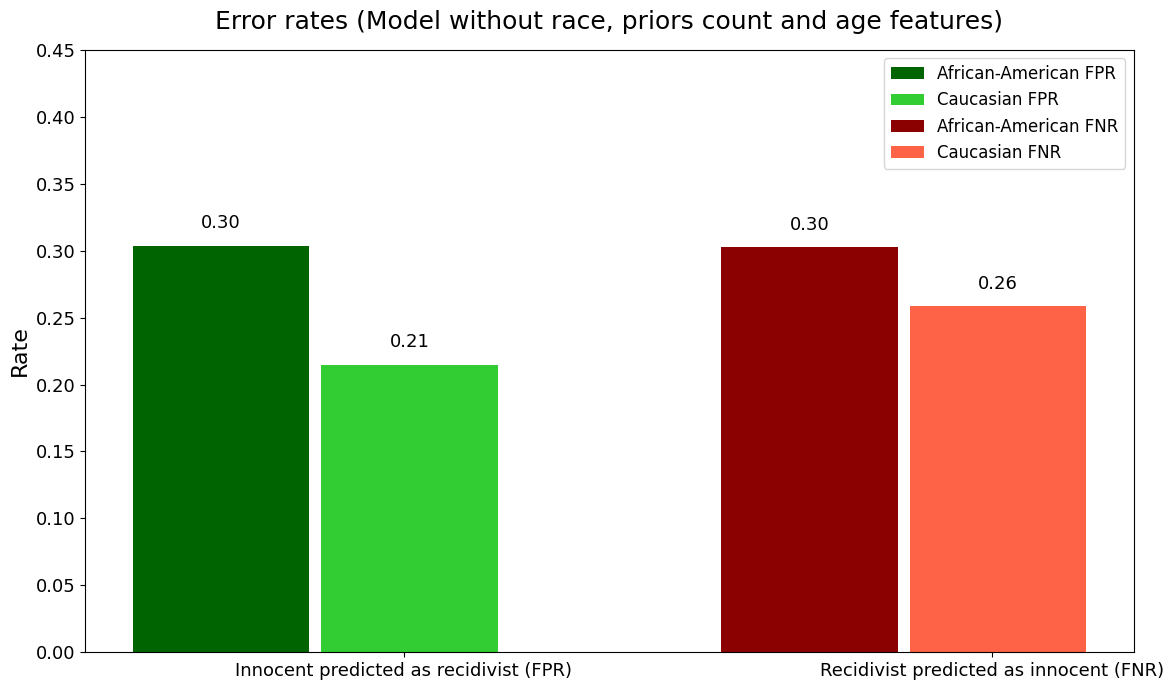

In [ ]:
# --------------------------
# 📊 Diagrama de barras verticales con etiquetas claras
# --------------------------
labels = [
    'Innocent predicted as recidivist (FPR)',
    'Recidivist predicted as innocent (FNR)'
]

# Valores
aa_values = [fpr_afam[0], fnr_afam[0]]
cauc_values = [fpr_cauc[0], fnr_cauc[0]]

x = range(len(labels))
bar_width = 0.3
separation = 0.02

fig, ax = plt.subplots(figsize=(12,7))

# Colores
color_aa_fpr = '#006400'   # verde oscuro
color_aa_fnr = '#8B0000'   # verde claro
color_cauc_fpr = '#32CD32' # rojo oscuro
color_cauc_fnr = '#FF6347' # rojo claro

# Barras FPR
ax.bar(
    0 - bar_width - separation/2,
    aa_values[0],
    width=bar_width,
    label='African-American FPR',
    color=color_aa_fpr
)
ax.bar(
    0 + separation/2,
    cauc_values[0],
    width=bar_width,
    label='Caucasian FPR',
    color=color_cauc_fpr
)

# Barras FNR
ax.bar(
    1 - bar_width - separation/2,
    aa_values[1],
    width=bar_width,
    label='African-American FNR',
    color=color_aa_fnr
)
ax.bar(
    1 + separation/2,
    cauc_values[1],
    width=bar_width,
    label='Caucasian FNR',
    color=color_cauc_fnr
)

# Etiquetas y detalles
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14, wrap=True)  # wrap para texto largo
ax.set_ylabel('Rate', fontsize=16)
ax.set_ylim([0,0.45])
ax.set_title('Error rates (Model without race, priors count and age features)', fontsize=18, pad=15)
ax.legend(fontsize=12)

# Mostrar valores encima de las barras
for xpos, value in zip([0 - bar_width - separation/2, 1 - bar_width - separation/2], aa_values):
    ax.text(xpos, value + 0.01, f"{value:.2f}", ha='center', va='bottom', fontsize=13)
for xpos, value in zip([0 + separation/2, 1 + separation/2], cauc_values):
    ax.text(xpos, value + 0.01, f"{value:.2f}", ha='center', va='bottom', fontsize=13)

# Ejes más grandes
ax.tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Iteratively remove most important features and check bias
remaining_features = list(feat_importances.index)
bias_tracking = []

for step in range(len(remaining_features)):
    # Remove top feature
    if step > 0:
        removed_feature = feat_importances.index[step-1]
        remaining_features = [f for f in remaining_features if f != removed_feature]

    # Retrain model
    X_train_subset = X_train[remaining_features]
    X_test_subset = X_test[remaining_features]
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_subset, y_train)
    y_pred_subset = model.predict(X_test_subset)

    # Measure accuracy
    acc = accuracy_score(y_test, y_pred_subset)

    # Measure bias
    bias_df = measure_bias(X_test_subset, y_test, y_pred_subset, 'race')
    # Extract FPR and FNR for African-American and Caucasian
    fpr_afam = bias_df.loc[bias_df['race'] == 'African-American', 'FPR'].values
    fpr_cauc = bias_df.loc[bias_df['race'] == 'Caucasian', 'FPR'].values
    fnr_afam = bias_df.loc[bias_df['race'] == 'African-American', 'FNR'].values
    fnr_cauc = bias_df.loc[bias_df['race'] == 'Caucasian', 'FNR'].values

    # Compute differences safely
    fpr_diff = fpr_afam[0] - fpr_cauc[0] if len(fpr_afam) and len(fpr_cauc) else None
    fnr_diff = fnr_afam[0] - fnr_cauc[0] if len(fnr_afam) and len(fnr_cauc) else None

    bias_tracking.append({
        'step': step,
        'removed_feature': removed_feature if step > 0 else None,
        'accuracy': acc,
        'FPR_diff': fpr_diff,
        'FNR_diff': fnr_diff
    })

# Convert to dataframe and display
bias_tracking_df = pd.DataFrame(bias_tracking)
print("\n Bias tracking as we remove features:")
print(bias_tracking_df)


 Bias tracking as we remove features:
    step      removed_feature  accuracy  FPR_diff  FNR_diff
0      0                 None  0.767184  0.102547 -0.073212
1      1  days_before_custody  0.674058  0.088321 -0.201263
2      2                  age  0.634701  0.117293 -0.124458
3      3      days_in_custody  0.608647  0.138079 -0.138170
4      4        c_charge_desc  0.648559  0.210107 -0.196245
5      5         priors_count  0.619180  0.536599 -0.617280
6      6                 race  0.610310  0.061758 -0.113760
7      7      c_charge_degree  0.613082  0.071337 -0.122289
8      8                  sex  0.610310  0.066548 -0.126645
9      9      juv_other_count  0.594789  0.065012 -0.093081
10    10       juv_misd_count  0.582594  0.030599 -0.057294



 Classification report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.78      1023
           1       0.71      0.76      0.73       781

    accuracy                           0.76      1804
   macro avg       0.76      0.76      0.76      1804
weighted avg       0.76      0.76      0.76      1804


 ROC AUC Score: 0.8297


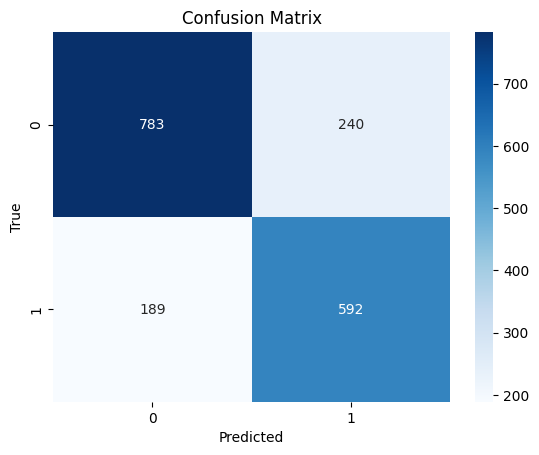

In [ ]:
X_ethnic_unbias = df.drop(columns=[target_1, target_2, target_3, target_4, 'race'], errors='ignore')

# Build train/test split
X_ethnic_unbias_train, X_ethnic_unbias_test, y_ethnic_unbias_train, y_ethnic_unbias_test = train_test_split(X_ethnic_unbias, y, test_size=0.25, random_state=42)

ethnic_unbias_model = RandomForestClassifier(n_estimators=500, random_state=42)
ethnic_unbias_model.fit(X_ethnic_unbias_train, y_ethnic_unbias_train)

# Predict and evaluate
y_ethnic_unbias_pred = ethnic_unbias_model.predict(X_ethnic_unbias_test)
y_ethnic_unbias_proba = ethnic_unbias_model.predict_proba(X_ethnic_unbias_test)[:, 1]

print("\n Classification report:")
print(classification_report(y_ethnic_unbias_test, y_ethnic_unbias_pred))

print(f"\n ROC AUC Score: {roc_auc_score(y_ethnic_unbias_test, y_ethnic_unbias_proba):.4f}")

cm = confusion_matrix(y_ethnic_unbias_test, y_ethnic_unbias_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Define your FPR/FNR functions
def false_positive_rate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0.0

def false_negative_rate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    return fn / (fn + tp) if (fn + tp) > 0 else 0.0

In [ ]:
race_mapping = dict(enumerate(encoders['race'].classes_))
race_names = X['race'].map(race_mapping)

# Keep only African-American and Caucasian
mask = race_names.isin(['African-American', 'Caucasian'])
X_filtered = X[mask].copy()
y_filtered = y[mask].copy()
race_filtered = race_names[mask].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42, stratify=y_filtered
)

# Sensitive feature for fairness
sensitive_train = X_train['race']
sensitive_test = X_test['race']
race_names_test = sensitive_test.map(race_mapping)

# ---- Baseline Model ----
baseline = RandomForestClassifier(n_estimators=500, random_state=42)
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)

mf_baseline = MetricFrame(
    metrics={'FPR': false_positive_rate, 'FNR': false_negative_rate, 'accuracy': accuracy_score},
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=race_names_test
)

print("\n📊 Baseline fairness metrics by race:")
print(mf_baseline.by_group)

# ---- Fairness-Aware Model (Equalized Odds) ----
base_estimator = LogisticRegression(max_iter=1000, solver='liblinear')
mitigator = GridSearch(estimator=base_estimator, constraints=EqualizedOdds(), grid_size=20)
mitigator.fit(X_train, y_train, sensitive_features=sensitive_train)
y_pred_fair = mitigator.predict(X_test)

mf_fair = MetricFrame(
    metrics={'FPR': false_positive_rate, 'FNR': false_negative_rate, 'accuracy': accuracy_score},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=race_names_test
)

print("\n✅ Fairness-aware model metrics by race:")
print(mf_fair.by_group)

# ---- Function: Print Confusion Matrices ----
def print_confusion_by_group(y_true, y_pred, group_names, label):
    print(f"\n🧮 Confusion Matrix Breakdown by Group: {label}")
    for group in ['African-American', 'Caucasian']:
        mask = (group_names == group)
        y_true_g = y_true[mask]
        y_pred_g = y_pred[mask]
        tn, fp, fn, tp = confusion_matrix(y_true_g, y_pred_g, labels=[0, 1]).ravel()
        print(f"🔹 {group}: TP={tp}, FP={fp}, TN={tn}, FN={fn}")

def print_overall_confusion(y_true, y_pred, label):
    print(f"\n📦 Overall Confusion Matrix: {label}")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")

# ---- Print confusion matrices ----
print_overall_confusion(y_test, y_pred_baseline, label="Baseline")
print_confusion_by_group(y_test, y_pred_baseline, race_names_test, label="Baseline")

print_overall_confusion(y_test, y_pred_fair, label="Fairness-Aware")
print_confusion_by_group(y_test, y_pred_fair, race_names_test, label="Fairness-Aware")

# ---- Summary ----
print("\n📌 Summary:")
print(f"Baseline accuracy: {accuracy_score(y_test, y_pred_baseline):.3f}")
print(f"Fairness-aware accuracy: {accuracy_score(y_test, y_pred_fair):.3f}")

fpr_diff_baseline = mf_baseline.by_group.loc['African-American', 'FPR'] - mf_baseline.by_group.loc['Caucasian', 'FPR']
fnr_diff_baseline = mf_baseline.by_group.loc['African-American', 'FNR'] - mf_baseline.by_group.loc['Caucasian', 'FNR']
fpr_diff_fair = mf_fair.by_group.loc['African-American', 'FPR'] - mf_fair.by_group.loc['Caucasian', 'FPR']
fnr_diff_fair = mf_fair.by_group.loc['African-American', 'FNR'] - mf_fair.by_group.loc['Caucasian', 'FNR']

print(f"\nBaseline FPR difference: {fpr_diff_baseline:.4f}")
print(f"Baseline FNR difference: {fnr_diff_baseline:.4f}")
print(f"Fair model FPR difference: {fpr_diff_fair:.4f}")
print(f"Fair model FNR difference: {fnr_diff_fair:.4f}")


📊 Baseline fairness metrics by race:
                       FPR       FNR  accuracy
race                                          
African-American  0.305122  0.255365  0.720219
Caucasian         0.169355  0.290837  0.781701

✅ Fairness-aware model metrics by race:
                       FPR       FNR  accuracy
race                                          
African-American  0.240535  0.420601  0.667760
Caucasian         0.282258  0.390438  0.674157

📦 Overall Confusion Matrix: Baseline
TP=525, FP=200, TN=621, FN=192

🧮 Confusion Matrix Breakdown by Group: Baseline
🔹 African-American: TP=347, FP=137, TN=312, FN=119
🔹 Caucasian: TP=178, FP=63, TN=309, FN=73

📦 Overall Confusion Matrix: Fairness-Aware
TP=423, FP=213, TN=608, FN=294

🧮 Confusion Matrix Breakdown by Group: Fairness-Aware
🔹 African-American: TP=270, FP=108, TN=341, FN=196
🔹 Caucasian: TP=153, FP=105, TN=267, FN=98

📌 Summary:
Baseline accuracy: 0.745
Fairness-aware accuracy: 0.670

Baseline FPR difference: 0.1358
Baseline 

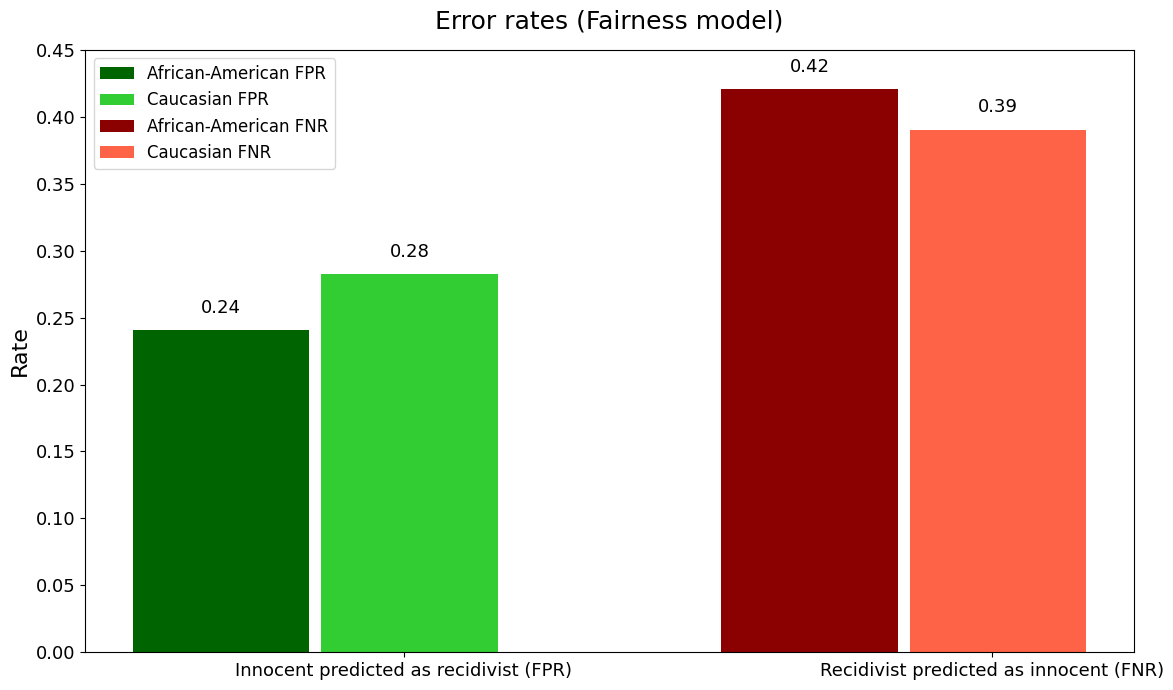

In [ ]:
# --------------------------
# 📊 Diagrama de barras verticales con etiquetas claras
# --------------------------
labels = [
    'Innocent predicted as recidivist (FPR)',
    'Recidivist predicted as innocent (FNR)'
]

# Valores
aa_values = [mf_fair.by_group.loc['African-American', 'FPR'], mf_fair.by_group.loc['African-American', 'FNR']]
cauc_values = [mf_fair.by_group.loc['Caucasian', 'FPR'], mf_fair.by_group.loc['Caucasian', 'FNR']]

x = range(len(labels))
bar_width = 0.3
separation = 0.02

fig, ax = plt.subplots(figsize=(12,7))

# Colores
color_aa_fpr = '#006400'   # verde oscuro
color_aa_fnr = '#8B0000'   # verde claro
color_cauc_fpr = '#32CD32' # rojo oscuro
color_cauc_fnr = '#FF6347' # rojo claro

# Barras FPR
ax.bar(
    0 - bar_width - separation/2,
    aa_values[0],
    width=bar_width,
    label='African-American FPR',
    color=color_aa_fpr
)
ax.bar(
    0 + separation/2,
    cauc_values[0],
    width=bar_width,
    label='Caucasian FPR',
    color=color_cauc_fpr
)

# Barras FNR
ax.bar(
    1 - bar_width - separation/2,
    aa_values[1],
    width=bar_width,
    label='African-American FNR',
    color=color_aa_fnr
)
ax.bar(
    1 + separation/2,
    cauc_values[1],
    width=bar_width,
    label='Caucasian FNR',
    color=color_cauc_fnr
)

# Etiquetas y detalles
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14, wrap=True)  # wrap para texto largo
ax.set_ylabel('Rate', fontsize=16)
ax.set_ylim([0,0.45])
ax.set_title('Error rates (Fairness model)', fontsize=18, pad=15)
ax.legend(fontsize=12)

# Mostrar valores encima de las barras
for xpos, value in zip([0 - bar_width - separation/2, 1 - bar_width - separation/2], aa_values):
    ax.text(xpos, value + 0.01, f"{value:.2f}", ha='center', va='bottom', fontsize=13)
for xpos, value in zip([0 + separation/2, 1 + separation/2], cauc_values):
    ax.text(xpos, value + 0.01, f"{value:.2f}", ha='center', va='bottom', fontsize=13)

# Ejes más grandes
ax.tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
plt.show()

# New models

In [ ]:
# === Run model function ===
def run_model(name, estimator, X_train, y_train, X_test, y_test, sensitive_train, sensitive_test, race_names_test):
    results = {}
    print(f"\n=== 🔍 MODEL: {name} ===")

    # --- Baseline ---
    print("📊 Baseline (no fairness constraint):")
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    mf_base = MetricFrame(
        metrics={'FPR': false_positive_rate, 'FNR': false_negative_rate, 'accuracy': accuracy_score},
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=race_names_test
    )
    print(mf_base.by_group)

    acc_base = accuracy_score(y_test, y_pred)
    fpr_diff_base = mf_base.by_group.loc['African-American', 'FPR'] - mf_base.by_group.loc['Caucasian', 'FPR']
    fnr_diff_base = mf_base.by_group.loc['African-American', 'FNR'] - mf_base.by_group.loc['Caucasian', 'FNR']

    # --- Fairness-Aware ---
    print("\n✅ Fairness-Aware (Equalized Odds):")
    #mitigator = GridSearch(estimator=estimator, constraints=EqualizedOdds(), grid_size=50)
    mitigator = ExponentiatedGradient(estimator, constraints=EqualizedOdds(), eps=0.001)
    mitigator.fit(X_train, y_train, sensitive_features=sensitive_train)
    y_pred_fair = mitigator.predict(X_test)

    mf_fair = MetricFrame(
        metrics={'FPR': false_positive_rate, 'FNR': false_negative_rate, 'accuracy': accuracy_score},
        y_true=y_test,
        y_pred=y_pred_fair,
        sensitive_features=race_names_test
    )
    print(mf_fair.by_group)

    acc_fair = accuracy_score(y_test, y_pred_fair)
    fpr_diff_fair = mf_fair.by_group.loc['African-American', 'FPR'] - mf_fair.by_group.loc['Caucasian', 'FPR']
    fnr_diff_fair = mf_fair.by_group.loc['African-American', 'FNR'] - mf_fair.by_group.loc['Caucasian', 'FNR']

    changed_preds = np.sum(y_pred != y_pred_fair)
    print(f"🔁 Predictions changed due to fairness constraint: {changed_preds} of {len(y_test)}")

    # --- Save Results ---
    results['Model'] = name
    results['Baseline Accuracy'] = acc_base
    results['Fair Accuracy'] = acc_fair
    results['FPR diff (Base)'] = fpr_diff_base
    results['FPR diff (Fair)'] = fpr_diff_fair
    results['FNR diff (Base)'] = fnr_diff_base
    results['FNR diff (Fair)'] = fnr_diff_fair
    results['Changed Predictions'] = changed_preds

    return results


In [ ]:
# ---------------------------
# 🎯 Preprocessing
# ---------------------------

# Step 1: Map race codes to names
race_mapping = dict(enumerate(encoders['race'].classes_))
race_names = X['race'].map(race_mapping)

# Step 2: Filter to African-American and Caucasian only
#mask = race_names.isin(['African-American', 'Caucasian'])
#X_filtered = X[mask].copy()
#y_filtered = y[mask].copy()
#race_filtered = race_names[mask].copy()

# Step 3: Split data
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, #stratify=y_filtered
)

# Step 4: Separate out sensitive feature (race)
sensitive_train = X_train_full['race']
sensitive_test = X_test_full['race']
race_names_test = sensitive_test.map(race_mapping)

X_train = X_train_full
X_test = X_test_full

#X_train_nonsensitive = X_train_full.drop(columns=['race'])
#X_test_nonsensitive = X_test_full.drop(columns=['race'])
#
## Step 5: Apply PCA to reduce to 4 dimensions
#pca = PCA(n_components=4)
#X_train_pca = pca.fit_transform(X_train_nonsensitive)
#X_test_pca = pca.transform(X_test_nonsensitive)
#
## Step 6: Convert PCA output back to DataFrames and reattach race
#X_train = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(4)])
#X_test = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(4)])
#
#X_train['race'] = sensitive_train.values
#X_test['race'] = sensitive_test.values

In [ ]:
# === Custom wrappers for RF and XGB ===
class RFWrapper(RandomForestClassifier):
    def decision_function(self, X):
        return self.predict_proba(X)[:, 1]

class XGBWrapper(XGBClassifier):
    def decision_function(self, X):
        return self.predict_proba(X)[:, 1]

In [ ]:
# === Run all models ===
all_results = []

models = [
    ("Random Forest", RFWrapper(n_estimators=500, random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, solver='liblinear')),
    ("XGBoost", XGBWrapper(eval_metric='logloss', random_state=42)),
    #("SVM", SVC(kernel='linear', probability=True)),
    #("KNN", KNeighborsClassifier(n_neighbors=5))
]

for name, estimator in models:
    res = run_model(name, estimator, X_train, y_train, X_test, y_test, sensitive_train, sensitive_test, race_names_test)
    all_results.append(res)

# === Display Summary Table ===
summary_df = pd.DataFrame(all_results)
print("\n📊 Summary Table:")
print(summary_df.round(4))